In [1]:
import matplotlib.pyplot as plt
from scipy import signal
import os
from scipy.signal import find_peaks
import pandas as pd
import numpy as np


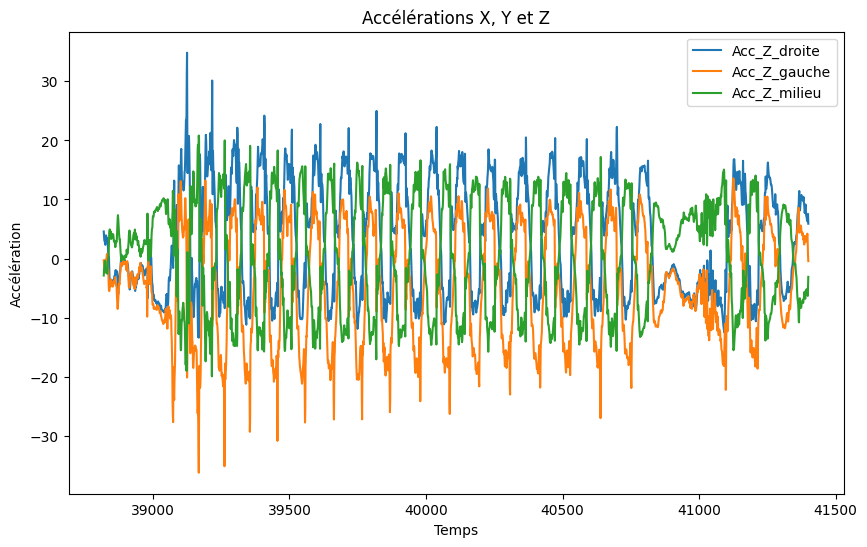

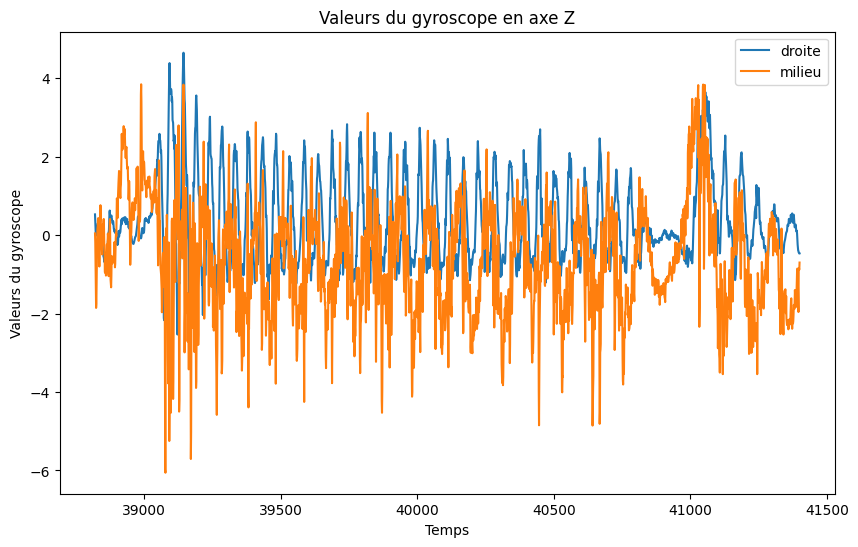

In [2]:
# Lire les fichiers CSV
droite = pd.read_csv("C:/Users/antho/Documents/Digisport/Semestre_3/Projet_kayak/data/Pagaie_droite.csv", delimiter= ",", skiprows= 7)
gauche = pd.read_csv("C:/Users/antho/Documents/Digisport/Semestre_3/Projet_kayak/data/Pagaie_gauche.csv", delimiter= ",", skiprows=7)
milieu = pd.read_csv("C:/Users/antho/Documents/Digisport/Semestre_3/Projet_kayak/data/Pagaie_milieu.csv", delimiter= ",", skiprows=7)
bateau = pd.read_csv("C:/Users/antho/Documents/Digisport/Semestre_3/Projet_kayak/data/Dot_Bateau.csv", delimiter= ",", skiprows=7)
torse = pd.read_csv("C:/Users/antho/Documents/Digisport/Semestre_3/Projet_kayak/data/Dot_Torse.csv", delimiter= ",", skiprows=7)

# Spécifier les temps de début et de fin en minutes et secondes
minute_debut, seconde_debut = 10, 47
minute_fin, seconde_fin = 11, 30

frame_debut = minute_debut * 60 * 60 + seconde_debut * 60  # Conversion en secondes
frame_fin = minute_fin * 60 * 60 + seconde_fin * 60    # Conversion en secondes

# Identifier les indices des lignes correspondant à cette plage de temps pour la première série (droite)
lent_1 = (droite['PacketCounter'] >= frame_debut) & (droite['PacketCounter'] <= frame_fin)

# Extraire les données de la plage de temps spécifiée
pagaie_droite_lent_1 = droite[lent_1]
pagaie_gauche_lent_1 = gauche[lent_1]
pagaie_milieu_lent_1 = milieu[lent_1]
torse_lent_1 = torse[lent_1]
bateau_lent_1 = bateau[lent_1]

# Créer un graphique pour les accélérations X, Y et Z
plt.figure(figsize=(10, 6))
plt.plot(pagaie_droite_lent_1['PacketCounter'], pagaie_droite_lent_1['Acc_X'], label='Acc_Z_droite')
plt.plot(pagaie_gauche_lent_1['PacketCounter'], pagaie_gauche_lent_1['Acc_X'], label='Acc_Z_gauche')
plt.plot(pagaie_milieu_lent_1['PacketCounter'], pagaie_milieu_lent_1['Acc_X'], label='Acc_Z_milieu')
plt.xlabel('Temps')
plt.ylabel('Accélération')
plt.title('Accélérations X, Y et Z')
plt.legend()


# Créer un graphique pour les valeurs du gyroscope en axe Z
plt.figure(figsize=(10, 6))
plt.plot(pagaie_droite_lent_1['PacketCounter'], bateau_lent_1['Acc_X'], label='droite')
plt.plot(pagaie_milieu_lent_1['PacketCounter'], torse_lent_1['Acc_Y'], label='milieu')
plt.xlabel('Temps')
plt.ylabel('Valeurs du gyroscope')
plt.title('Valeurs du gyroscope en axe Z')
plt.legend()


plt.show()

## Estimation nombre de coup de pagaie

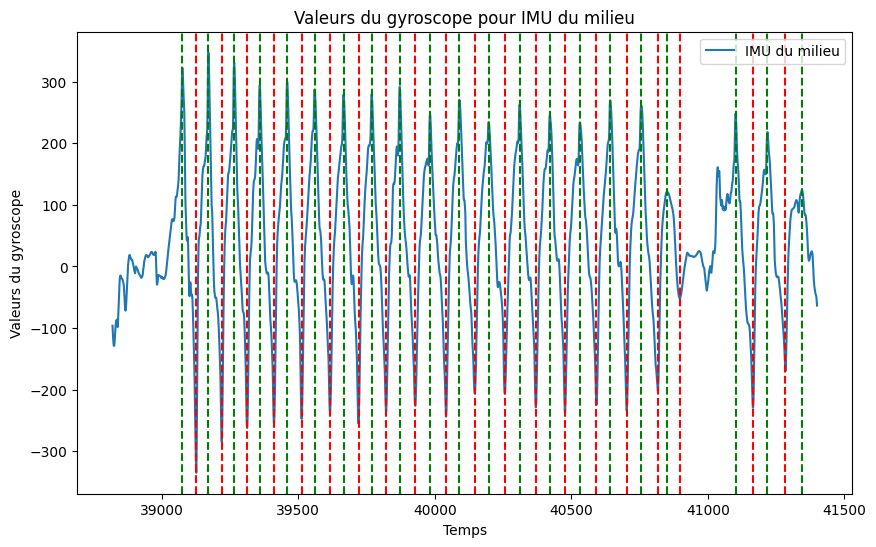

Nombre de pics positifs : 21
Nombre de pics négatifs : 20


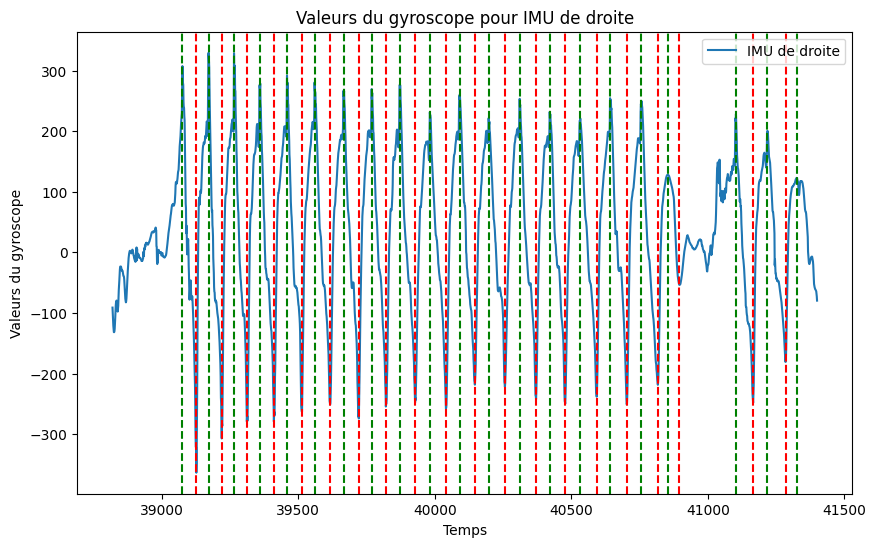

Nombre de pics positifs : 21
Nombre de pics négatifs : 20


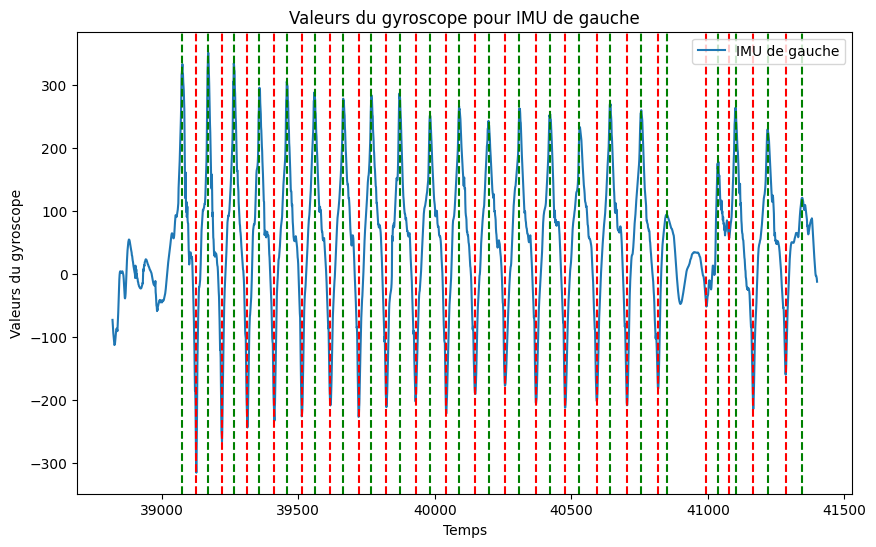

Nombre de pics positifs : 22
Nombre de pics négatifs : 21


In [3]:
def detecter_pics(data, threshold_pos, threshold_neg, prominence=80, distance=2, width=1):
    # Trouver les pics positifs
    pic_positifs, _ = find_peaks(data, height=threshold_pos, distance=distance, prominence=prominence, width=width)

    # Trouver les pics négatifs
    pic_negatifs, _ = find_peaks(-data, height=threshold_neg, distance=distance, prominence=prominence, width=width)

    return pic_positifs, pic_negatifs

def afficher_graphique(data, pic_positifs, pic_negatifs, label):
    plt.figure(figsize=(10, 6))
    plt.plot(data, label=label)
    plt.xlabel('Temps')
    plt.ylabel('Valeurs du gyroscope')
    plt.title(f'Valeurs du gyroscope pour {label}')
    plt.legend()

    # Tracé des lignes verticales pour chaque pic détecté
    for pic in pic_positifs:
        plt.axvline(x=frame_debut + pic, color='g', linestyle='--', label='Pic positif')

    for pic in pic_negatifs:
        plt.axvline(x=frame_debut + pic, color='r', linestyle='--', label='Pic négatif')

    plt.show()

def compter_pics(pic_positifs, pic_negatifs):
    print(f"Nombre de pics positifs : {len(pic_positifs)}")
    print(f"Nombre de pics négatifs : {len(pic_negatifs)}")

pic_positifs_milieu, pic_negatifs_milieu = detecter_pics(pagaie_milieu_lent_1['Gyr_Z'], 80, -80,prominence=120)
afficher_graphique(pagaie_milieu_lent_1['Gyr_Z'], pic_positifs_milieu, pic_negatifs_milieu, "IMU du milieu")
compter_pics(pic_positifs_milieu, pic_negatifs_milieu)

pic_positifs_droite, pic_negatifs_droite = detecter_pics(pagaie_droite_lent_1['Gyr_Z'], 80, -80,prominence=120)
afficher_graphique(pagaie_droite_lent_1['Gyr_Z'], pic_positifs_droite, pic_negatifs_droite, "IMU de droite")
compter_pics(pic_positifs_droite, pic_negatifs_droite)

pic_positifs_gauche, pic_negatifs_gauche = detecter_pics(pagaie_gauche_lent_1['Gyr_Z'], 80, -80,prominence=120)
afficher_graphique(pagaie_gauche_lent_1['Gyr_Z'], pic_positifs_gauche, pic_negatifs_gauche, "IMU de gauche")
compter_pics(pic_positifs_gauche, pic_negatifs_gauche)



## Fréquence coup de pagaie

In [154]:
def calculer_frequence_coups_pagaie(pic_positifs, pic_negatifs, sampling_rate):
    # Nombre total de pics
    total_pics = len(pic_positifs) + len(pic_negatifs)
    
    # Nombre total d'échantillons
    total_samples = max(max(pic_positifs), max(pic_negatifs))
    
    # Durée totale en secondes
    total_time_seconds = total_samples / sampling_rate
    
    # Calcul de la fréquence des coups de pagaie en Hz
    frequency_hz = total_pics / total_time_seconds
    
    # Conversion en coups par minute (CPM)
    frequency_cpm = frequency_hz * 60
    
    return frequency_cpm

# Utilisation de la fonction avec les différentes variables
frequency_cpm_gauche = calculer_frequence_coups_pagaie(pic_positifs_gauche, pic_negatifs_gauche, 60)
frequency_cpm_droit = calculer_frequence_coups_pagaie(pic_positifs_droite, pic_negatifs_droite, 60)
frequency_cpm_milieu = calculer_frequence_coups_pagaie(pic_positifs_milieu, pic_negatifs_droite, 60)

print(f"Fréquence des coups de pagaie côté gauche : {frequency_cpm_gauche} CPM")
print(f"Fréquence des coups de pagaie côté droit : {frequency_cpm_droit} CPM")
print(f"Fréquence des coups de pagaie côté milieu : {frequency_cpm_milieu} CPM")



Fréquence des coups de pagaie côté gauche : 61.282660332541575 CPM
Fréquence des coups de pagaie côté droit : 58.92215568862275 CPM
Fréquence des coups de pagaie côté milieu : 58.47860538827258 CPM


## Norme sur X, Y et Z

<function matplotlib.pyplot.show(close=None, block=None)>

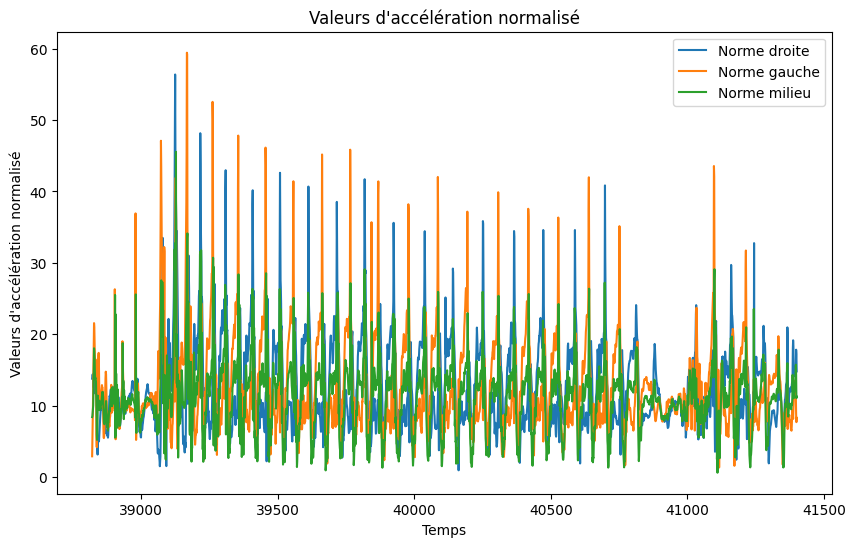

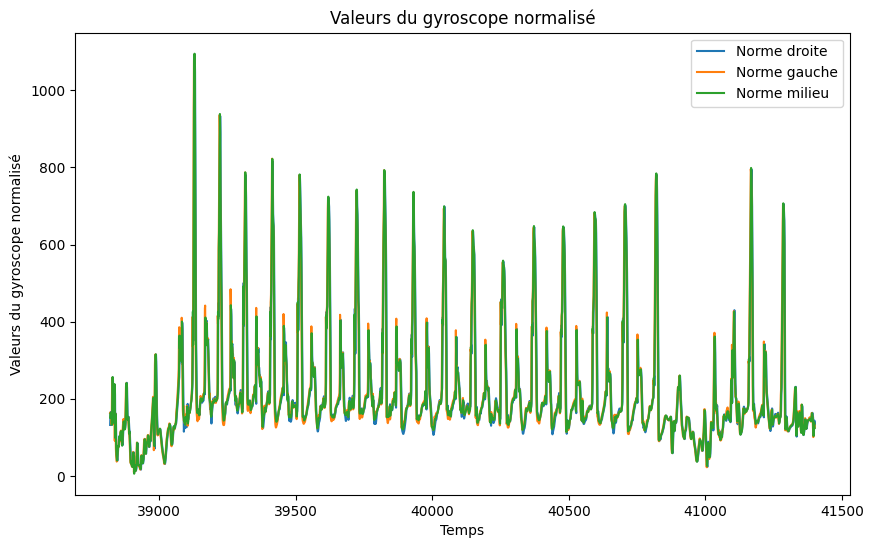

In [4]:
pagaie_droite_norm_gyr = np.sqrt(pagaie_droite_lent_1['Gyr_X']**2 + pagaie_droite_lent_1['Gyr_Y']**2 + pagaie_droite_lent_1['Gyr_Z']**2)
pagaie_gauche_norm_gyr = np.sqrt(pagaie_gauche_lent_1['Gyr_X']**2 + pagaie_gauche_lent_1['Gyr_Y']**2 + pagaie_gauche_lent_1['Gyr_Z']**2)
pagaie_milieu_norm_gyr = np.sqrt(pagaie_milieu_lent_1['Gyr_X']**2 + pagaie_milieu_lent_1['Gyr_Y']**2 + pagaie_milieu_lent_1['Gyr_Z']**2)

pagaie_droite_norm_acc = np.sqrt(pagaie_droite_lent_1['Acc_X']**2 + pagaie_droite_lent_1['Acc_Y']**2 + pagaie_droite_lent_1['Acc_Z']**2)
pagaie_gauche_norm_acc = np.sqrt(pagaie_gauche_lent_1['Acc_X']**2 + pagaie_gauche_lent_1['Acc_Y']**2 + pagaie_gauche_lent_1['Acc_Z']**2)
pagaie_milieu_norm_acc = np.sqrt(pagaie_milieu_lent_1['Acc_X']**2 + pagaie_milieu_lent_1['Acc_Y']**2 + pagaie_milieu_lent_1['Acc_Z']**2)

plt.figure(figsize=(10, 6))
plt.plot(pagaie_milieu_lent_1['PacketCounter'], pagaie_droite_norm_acc, label='Norme droite')
plt.plot(pagaie_milieu_lent_1['PacketCounter'], pagaie_gauche_norm_acc, label='Norme gauche')
plt.plot(pagaie_milieu_lent_1['PacketCounter'], pagaie_milieu_norm_acc, label='Norme milieu')
plt.xlabel('Temps')
plt.ylabel("Valeurs d'accélération normalisé")
plt.title("Valeurs d'accélération normalisé")
plt.legend()
plt.show

plt.figure(figsize=(10, 6))
plt.plot(pagaie_milieu_lent_1['PacketCounter'], pagaie_droite_norm_gyr, label='Norme droite')
plt.plot(pagaie_milieu_lent_1['PacketCounter'], pagaie_gauche_norm_gyr, label='Norme gauche')
plt.plot(pagaie_milieu_lent_1['PacketCounter'], pagaie_milieu_norm_gyr, label='Norme milieu')
plt.xlabel('Temps')
plt.ylabel('Valeurs du gyroscope normalisé')
plt.title('Valeurs du gyroscope normalisé')
plt.legend()
plt.show







## Norme sur Y et Z

<function matplotlib.pyplot.show(close=None, block=None)>

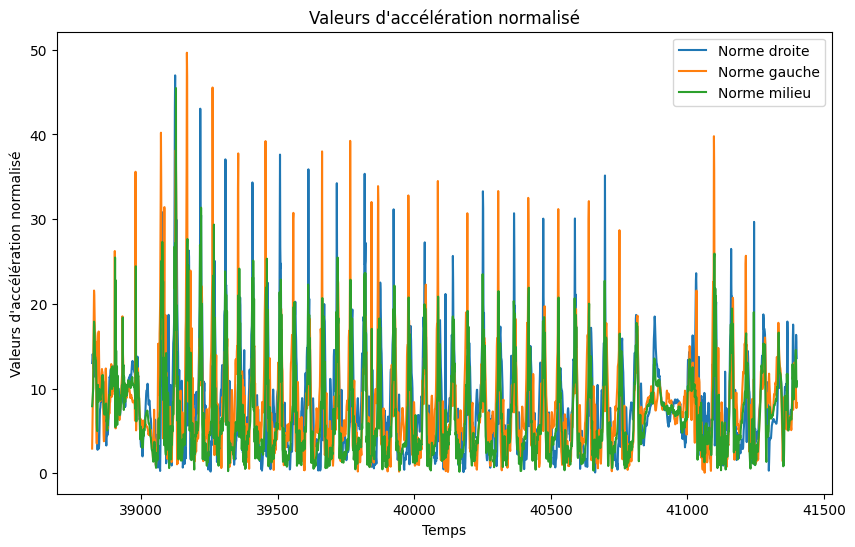

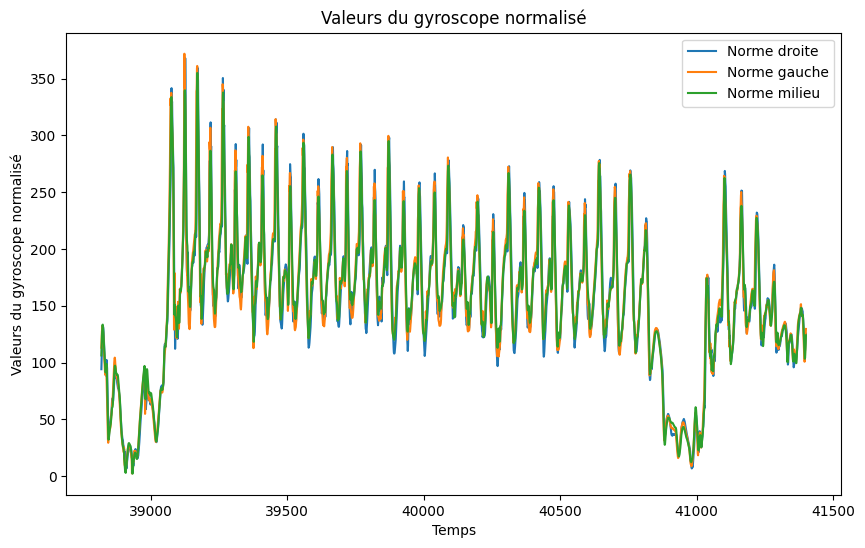

In [6]:
pagaie_droite_norm_gyr = np.sqrt(pagaie_droite_lent_1['Gyr_Y']**2 + pagaie_droite_lent_1['Gyr_Z']**2)
pagaie_gauche_norm_gyr = np.sqrt(pagaie_gauche_lent_1['Gyr_Y']**2 + pagaie_gauche_lent_1['Gyr_Z']**2)
pagaie_milieu_norm_gyr = np.sqrt(pagaie_milieu_lent_1['Gyr_Y']**2 + pagaie_milieu_lent_1['Gyr_Z']**2)

pagaie_droite_norm_acc = np.sqrt(pagaie_droite_lent_1['Acc_Y']**2 + pagaie_droite_lent_1['Acc_Z']**2)
pagaie_gauche_norm_acc = np.sqrt(pagaie_gauche_lent_1['Acc_Y']**2 + pagaie_gauche_lent_1['Acc_Z']**2)
pagaie_milieu_norm_acc = np.sqrt(pagaie_milieu_lent_1['Acc_Y']**2 + pagaie_milieu_lent_1['Acc_Z']**2)




plt.figure(figsize=(10, 6))
plt.plot(pagaie_milieu_lent_1['PacketCounter'], pagaie_droite_norm_acc, label='Norme droite')
plt.plot(pagaie_milieu_lent_1['PacketCounter'], pagaie_gauche_norm_acc, label='Norme gauche')
plt.plot(pagaie_milieu_lent_1['PacketCounter'], pagaie_milieu_norm_acc, label='Norme milieu')
plt.xlabel('Temps')
plt.ylabel("Valeurs d'accélération normalisé")
plt.title("Valeurs d'accélération normalisé")
plt.legend()
plt.show

plt.figure(figsize=(10, 6))
plt.plot(pagaie_milieu_lent_1['PacketCounter'], pagaie_droite_norm_gyr, label='Norme droite')
plt.plot(pagaie_milieu_lent_1['PacketCounter'], pagaie_gauche_norm_gyr, label='Norme gauche')
plt.plot(pagaie_milieu_lent_1['PacketCounter'], pagaie_milieu_norm_gyr, label='Norme milieu')
plt.xlabel('Temps')
plt.ylabel('Valeurs du gyroscope normalisé')
plt.title('Valeurs du gyroscope normalisé')
plt.legend()
plt.show


## Vitesse bateau par rapport au gyroscope 

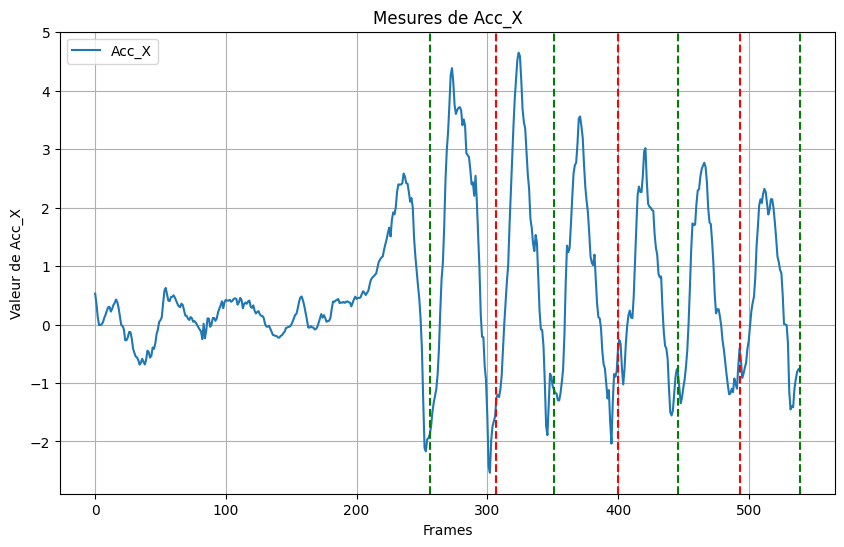

In [5]:

# Récupération des données pour les frames spécifiées
frames = range(0, 540)  # Frames de 173 à 337
Acceleration_bateau_x = bateau_lent_1['Acc_X'][0:540]  # Sélection des données de Gyr_X pour les frames spécifiées

# Création du graphique
plt.figure(figsize=(10, 6))
plt.plot(frames, Acceleration_bateau_x, label='Acc_X')

plt.title('Mesures de Acc_X')
plt.xlabel('Frames')
plt.ylabel('Valeur de Acc_X')
plt.legend()
plt.grid(True)


# Filtrage des indices des pics dans l'intervalle spécifié
pics_positifs_filtres = list(filter(lambda x: x in frames, pic_positifs_milieu))
pics_negatifs_filtres = list(filter(lambda x: x in frames, pic_negatifs_milieu))


for pic in pics_positifs_filtres:
    plt.axvline(x= pic, color='g', linestyle='--', label='Pic positif')

for pic in pics_negatifs_filtres:
    plt.axvline(x= pic, color='r', linestyle='--', label='Pic négatif')

plt.show()

## Torse

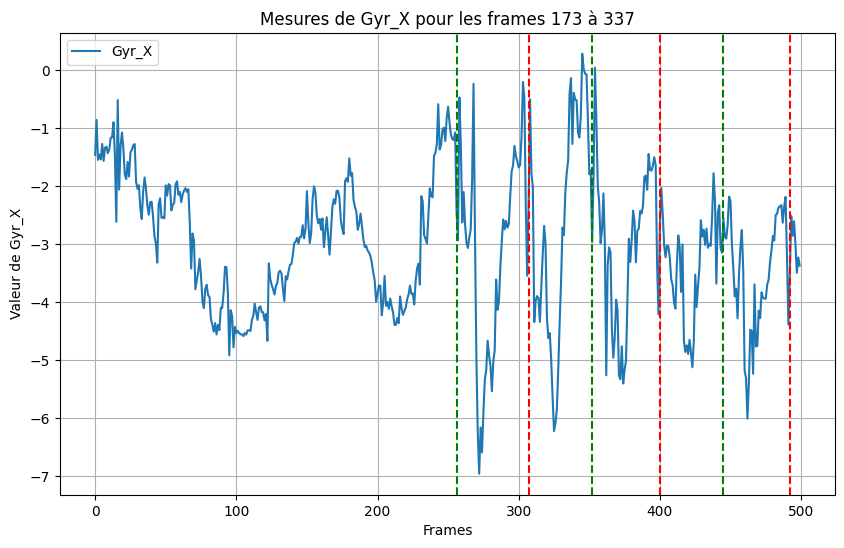

In [129]:

# Récupération des données pour les frames spécifiées
frames = range(0, 500)  # Frames de 173 à 337
gyr_x_data = torse_lent_1['Acc_Z'][0:500]  # Sélection des données de Gyr_X pour les frames spécifiées

# Création du graphique
plt.figure(figsize=(10, 6))
plt.plot(frames, gyr_x_data, label='Gyr_X')
plt.title('Mesures de Gyr_X pour les frames 173 à 337')
plt.xlabel('Frames')
plt.ylabel('Valeur de Gyr_X')
plt.legend()
plt.grid(True)


# Filtrage des indices des pics dans l'intervalle spécifié
pics_positifs_filtres = list(filter(lambda x: x in frames, pic_positifs))
pics_negatifs_filtres = list(filter(lambda x: x in frames, pic_negatifs))


for pic in pics_positifs_filtres:
    plt.axvline(x= pic, color='g', linestyle='--', label='Pic positif')

for pic in pics_negatifs_filtres:
    plt.axvline(x=pic, color='r', linestyle='--', label='Pic négatif')

plt.show()

## Accélération bateau et norme gyroscope en Z de la pagaie

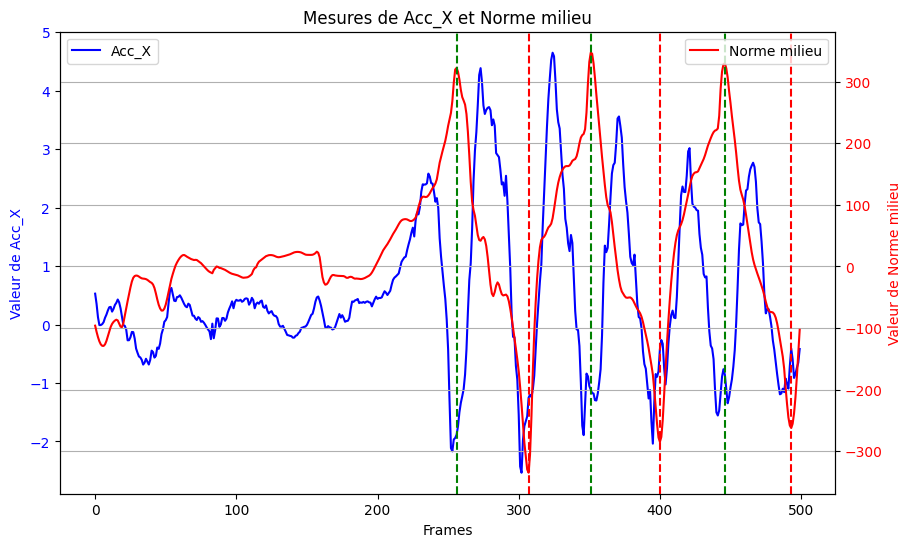

In [7]:
t0=0
t1=500

Acceleration_bateau_x_abs = [abs(acc) for acc in bateau_lent_1['Acc_X'][t0:t1]]

# Récupération des données pour les frames spécifiées
frames = range(t0, t1)  # Frames de 173 à 337

Acceleration_bateau_x = bateau_lent_1['Acc_X'][t0:t1]
Acceleration_pagaie_milieu_x = pagaie_milieu_lent_1['Gyr_Z'][t0:t1]

#Acceleration_pagaie_milieu_x = pagaie_milieu_norm_gyr[t0:t1]
#Acceleration_bateau_x = Acceleration_bateau_x_abs[t0:t1]


pagaie_milieu_norm_gyr
  # Sélection des données de Gyr_X pour les frames spécifiées

# Création du graphique avec deux échelles d'ordonnées
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot pour la première série de données avec l'axe des ordonnées ax1
ax1.plot(frames, Acceleration_bateau_x, label='Acc_X', color='b')
ax1.set_xlabel('Frames')
ax1.set_ylabel('Valeur de Acc_X', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')

# Création d'un deuxième axe des ordonnées partageant le même axe des abscisses
ax2 = ax1.twinx()

# Plot pour la deuxième série de données avec l'axe des ordonnées ax2
ax2.plot(frames, Acceleration_pagaie_milieu_x, label='Norme milieu', color='r')
ax2.set_ylabel('Valeur de Norme milieu', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

# Filtrage des indices des pics dans l'intervalle spécifié
pics_positifs_filtres = [pic for pic in pic_positifs_milieu if pic in frames]
pics_negatifs_filtres = [pic for pic in pic_negatifs_milieu if pic in frames]

for pic in pics_positifs_filtres:
    plt.axvline(x=pic, color='g', linestyle='--', label='Pic positif')

for pic in pics_negatifs_filtres:
    plt.axvline(x=pic, color='r', linestyle='--', label='Pic négatif')

plt.title('Mesures de Acc_X et Norme milieu')
plt.grid(True)
plt.show()


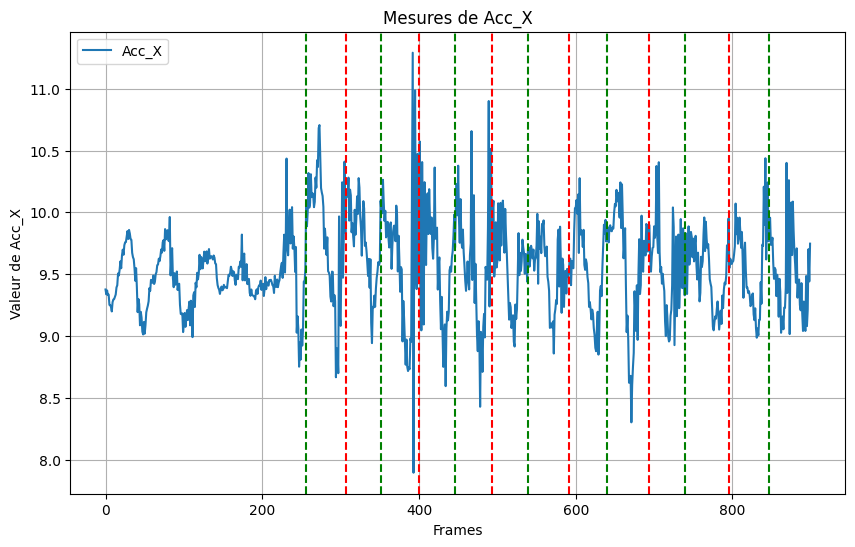

In [13]:
bateau_norm = np.sqrt(bateau_lent_1['Acc_X']**2 + bateau_lent_1['Acc_Y']**2 + bateau_lent_1['Acc_Z']**2)

# Récupération des données pour les frames spécifiées
frames = range(0, 900)  # Frames de 173 à 337
Acceleration_bateau_x = bateau_norm[0:900]  # Sélection des données de Gyr_X pour les frames spécifiées

# Création du graphique
plt.figure(figsize=(10, 6))
plt.plot(frames, Acceleration_bateau_x, label='Acc_X')

plt.title('Mesures de Acc_X')
plt.xlabel('Frames')
plt.ylabel('Valeur de Acc_X')
plt.legend()
plt.grid(True)


# Filtrage des indices des pics dans l'intervalle spécifié
pics_positifs_filtres = list(filter(lambda x: x in frames, pic_positifs_milieu))
pics_negatifs_filtres = list(filter(lambda x: x in frames, pic_negatifs_milieu))


for pic in pics_positifs_filtres:
    plt.axvline(x= pic, color='g', linestyle='--', label='Pic positif')

for pic in pics_negatifs_filtres:
    plt.axvline(x= pic, color='r', linestyle='--', label='Pic négatif')

plt.show()

In [6]:
import numpy as np

# Supposons que dt soit l'intervalle de temps entre chaque frame (en secondes)
# Il est important de connaître cet intervalle pour calculer la vitesse
dt = 60  # Remplace cela par la valeur réelle de l'intervalle de temps si disponible

# Accélération initiale (première valeur de la liste)
acc_initial = Acceleration_bateau_x[0]

# Calcul de la vitesse à partir de l'accélération en intégrant numériquement
velocities = [0.5 * (acc_initial + acc) * dt for acc in Acceleration_bateau_x]
velocities = np.cumsum(velocities)

# Création du graphique de la vitesse
plt.figure(figsize=(10, 6))
plt.plot(frames, velocities, label='Vitesse', color='b')

plt.title('Estimation de la vitesse à partir de Acc_X')
plt.xlabel('Frames')
plt.ylabel('Vitesse')
plt.legend()
plt.grid(True)
plt.show()


KeyError: 0